# Backpropagation in Multilayer Neural Networks

While we will primarily be working with high-level, abstract toolkits like Keras in this course, understanding how backpropagation works is absolutely essential to using neural networks. 

In this exercise, we will build our own backpropagation algorithm - working through each step, to ensure that we can follow it.

Just like in Lab 1, we'll be working with the MNIST dataset. We will load it and plot an example:

In [314]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

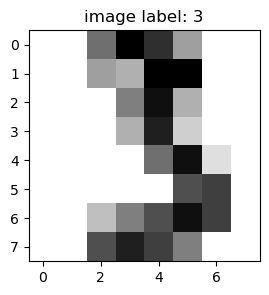

In [315]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

Of course, we need to split our data into training and testing sets before we use it, just the same as in Lab 1:

In [316]:
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement the softmax function $\sigma(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$;
- Implement the negative log likelihood function $NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}$;
- Train a logistic regression model on the MNIST dataset;
- Evaluate the model on the training and testing sets.

Before we get there, let's write a function that one-hot encodes the class labels:

In [317]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

# Test one_hot function 
print(one_hot(10, 3)) 

# Should print a one-hot encoded vector for class 3 
print(one_hot(10, [0, 4, 9, 1])) # Should print a batch of one-hot encoded vectors

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [318]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [319]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now we will implement the softmax function. Recall that the softmax function is defined as follows:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

This is implemented for you using numpy - we want to be able to apply the softmax function to a batch of samples at once, so we will use numpy's vectorized operations to do so.

Our method also handles _stability issues_ that can occur when the values in `X` are very large. We will subtract the maximum value from each row of `X` to avoid overflow in the exponentiation. This isn't part of the softmax function itself, but it's a useful trick to know about.

In [320]:
def softmax(X):
    X_max = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - X_max) # Subtract the max to avoid overflow in the exponentiation
    return exp / np.sum(exp, axis=-1, keepdims=True)


Let's make sure that this works one vector at a time (and check that the components sum to one):

In [321]:
print(softmax([10, 2, -3]))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]


When we are using our model to make predictions, we will want to be able to make predictions for multiple samples at once.
Let's make sure that our implementation of softmax works for a batch of samples:

In [322]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


Probabilities should sum to 1:

In [323]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [324]:
print("softmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

softmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [325]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Now we will implement a function that, given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred`, returns the negative log likelihood.

Recall that the negative log likelihood is defined as follows:

$$
NLL(Y_{true}, Y_{pred}) = - \sum_{i=1}^{n}{y_{true, i} \cdot \log(y_{pred, i})}
$$

For example, if we have $y_{true} = [1, 0, 0]$ and $y_{pred} = [0.99, 0.01, 0]$, then the negative log likelihood is $- \log(0.99) \approx 0.01$.

In [326]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)

    # Ensure Y_pred doesn't have zero probabilities to avoid log(0)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)

    # Calculate negative log likelihood
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.01005033585350145


We should see a very high value for this negative log likelihood, since the model is very confident that the third class is the correct one, but the true class is the first one:

In [327]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

4.605170185988091


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [328]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.010050335853503449


Now that we have our softmax and negative log likelihood functions, we can implement a logistic regression model. 
In this section, we have built the model for you, but you will need to complete a few key parts.

In [329]:
class LogisticRegression:

    def __init__(self, input_size, output_size):
        # Initialize the weights and biases with random numbers
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        
        # Store the input size and output size
        self.output_size = output_size
        self.input_size = input_size
    
    def forward(self, X): 
        # Compute the linear combination of the input and weights 
        Z = np.dot(X, self.W) + self.b 

        # Return the softmax of the linear combination 
        return softmax(Z)
    
    def predict(self, X):
        # Return the most probable class for each sample in X
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
            
    def loss(self, X, y):
        # Compute the negative log likelihood over the data provided
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X) 
        return nll(y_onehot, y_pred)

    def grad_loss(self, X, y_true, y_pred):
        # Compute the gradient of the loss with respect to W and b for a single sample (X, y_true)
        # y_pred is the output of the forward pass
    
        # Gradient with respect to weights
        grad_W = np.dot(X.T, (y_pred - y_true))
    
        # Gradient with respect to biases
        grad_b = np.sum(y_pred - y_true, axis=0)
    
        return grad_W, grad_b

In [330]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

We can evaluate the model on an example, visualizing the prediction probabilities:

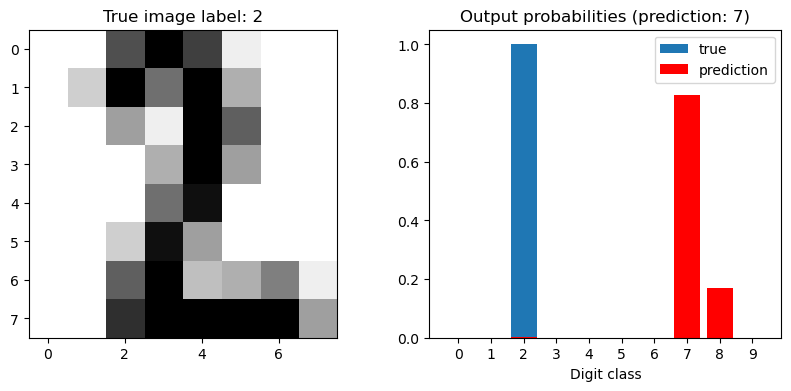

In [331]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    ax0.imshow(X_test[sample_idx:sample_idx+1].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()
    
plot_prediction(lr, sample_idx=0)

Now it's time to start training! We will train for a single epoch, and then evaluate the model on the training and testing sets. Read through the following and make sure that you understand what we are doing here.

In [332]:
lr = LogisticRegression(input_size=X_train.shape[1], output_size=10)

learning_rate = 0.01

for i in range(len(X_train)):
    # Get the current sample and corresponding label
    x = X_train[i:i+1]  # Reshape to keep the batch dimension
    y = y_train[i:i+1]  # Reshape to keep the batch dimension

    # Compute the forward pass and the gradient of the loss with respect to W and b
    y_pred = lr.forward(x)
    grad_W, grad_b = lr.grad_loss(x, one_hot(lr.output_size, y), y_pred)

    # Update the weights and biases
    lr.W -= learning_rate * grad_W
    lr.b -= learning_rate * grad_b

    # Print the average negative log likelihood every 100 steps
    if i % 100 == 0:
        avg_nll = lr.loss(X_train[max(0, i-100):i], y_train[max(0, i-100):i])
        print("Average NLL over the last 100 samples at step %d: %0.f" % (i, avg_nll))


Average NLL over the last 100 samples at step 0: -0
Average NLL over the last 100 samples at step 100: 631
Average NLL over the last 100 samples at step 200: 190
Average NLL over the last 100 samples at step 300: 240
Average NLL over the last 100 samples at step 400: 127
Average NLL over the last 100 samples at step 500: 169
Average NLL over the last 100 samples at step 600: 47
Average NLL over the last 100 samples at step 700: 88
Average NLL over the last 100 samples at step 800: 131
Average NLL over the last 100 samples at step 900: 118
Average NLL over the last 100 samples at step 1000: 421
Average NLL over the last 100 samples at step 1100: 92
Average NLL over the last 100 samples at step 1200: 139
Average NLL over the last 100 samples at step 1300: 41
Average NLL over the last 100 samples at step 1400: 55
Average NLL over the last 100 samples at step 1500: 81


Evaluate the trained model on the first example:

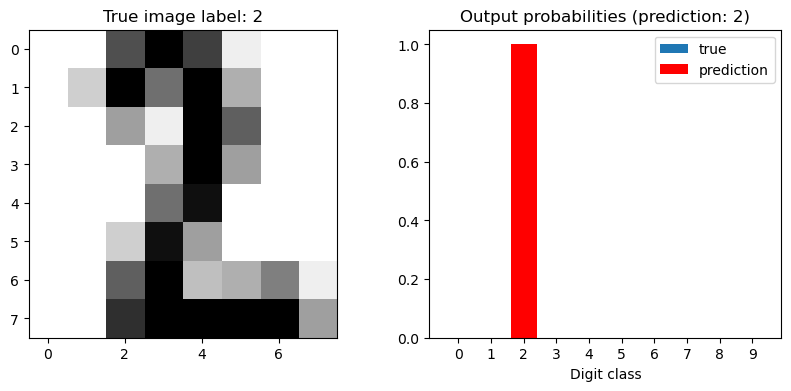

In [333]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

Now it's your turn to

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

Remember that you can use your `sigmoid` function inside your `dsigmoid` function.

Just like with our softmax function, we also want to make sure that we don't run into stability issues with our sigmoid function. We will use `np.clip` to ensure that the input to the sigmoid function is not too large or too small.

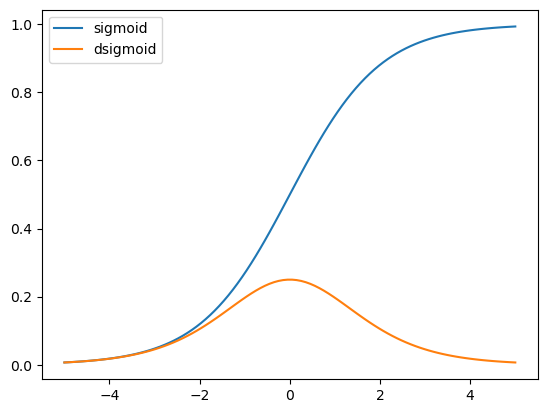

In [334]:
def sigmoid(X):
    # Clip X to prevent overflow or underflow
    X = np.clip(X, -500, 500) # This ensures that np.exp(X) doesn't overflow
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    # Calculate the sigmoid of X
    sig = sigmoid(X)
    return sig * (1 - sig)

x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best')
plt.show()


Now it's your turn to complete the neural network code, so that we can train it on the MNIST dataset.

Some parts have been completed for you already. Often, you'll be able to refer back to the code from the previous section to help you complete the code in this section.

In [335]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        # Initializes the weights with random numbers
        self.W_h = np.random.uniform(size=(input_size, hidden_size),
                                     high=0.1, low=-0.1)
        self.b_h = np.random.uniform(size=hidden_size,
                                     high=0.1, low=-0.1)
        self.W_o = np.random.uniform(size=(hidden_size, output_size),
                                     high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size,
                                     high=0.1, low=-0.1)

        # Store the input size, hidden size and output size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
    
    def forward_hidden(self, X):
        # Compute the linear combination of the input and weights
        self.Z_h = np.dot(X, self.W_h) + self.b_h
        
        # Apply the sigmoid activation function
        return sigmoid(self.Z_h)

    def forward_output(self, H):
        # Compute the linear combination of the hidden layer activation and weights
        self.Z_o = np.dot(H, self.W_o) + self.b_o

        # Apply the softmax activation function
        return softmax(self.Z_o)

    def forward(self, X):
        # Compute the forward activations of the hidden and output layers
        H = self.forward_hidden(X)
        Y = self.forward_output(H)
        return Y
    
    def loss(self, X, y): 
        y_onehot = one_hot(self.output_size, y) 
        y_pred = self.forward(X) 
        return nll(y_onehot, y_pred)

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        # Compute the error at the output layer
        error_o = y_pred - y_true

        # Compute the gradient of the loss with respect to W_o and b_o
        grad_W_o = np.dot(self.Z_h.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        # Compute the error at the hidden layer
        error_h = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h)

        # Compute the gradient of the loss with respect to W_h and b_h
        grad_W_h = np.dot(X.T, error_h)
        grad_b_h = np.sum(error_h, axis=0)
        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}

    def train(self, x, y, learning_rate):
        # Ensure x is 2D
        x = x[np.newaxis, :]
        # Compute the gradient for the sample and update the weights
        grads = self.grad_loss(x, y)
    
        self.W_h -= learning_rate * grads["W_h"]
        self.b_h -= learning_rate * grads["b_h"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]
        
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

Once the code is written, we can test our model on a single sample:

In [336]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)
print(model.forward(X_train[0]))

[0.11240683 0.12184339 0.11045069 0.09558474 0.09558978 0.07168971
 0.08139861 0.09843303 0.12389606 0.08870717]


In [337]:
model.loss(X_train, y_train)

3518.056593293063

In [338]:
model.accuracy(X_train, y_train)

0.08840864440078586

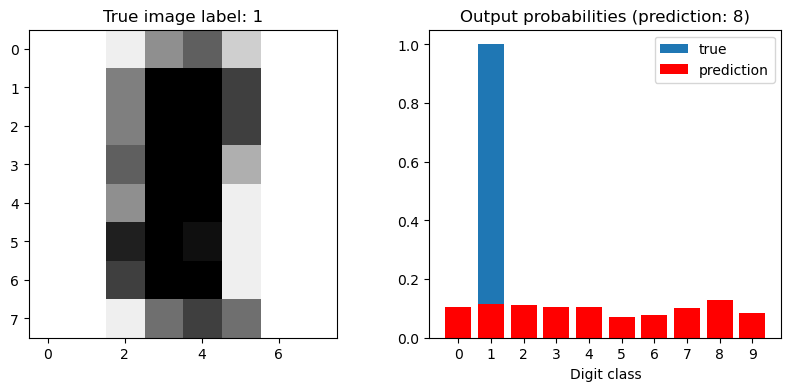

In [339]:
plot_prediction(model, sample_idx=5)

And now it's time to train!

In [340]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.001)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 3518.05659, train acc: 0.088, test acc: 0.130
Epoch #1, train loss: 2613.34080, train acc: 0.460, test acc: 0.448
Epoch #2, train loss: 1924.60105, train acc: 0.669, test acc: 0.644
Epoch #3, train loss: 1582.98315, train acc: 0.754, test acc: 0.726
Epoch #4, train loss: 1426.91958, train acc: 0.783, test acc: 0.759
Epoch #5, train loss: 1345.08204, train acc: 0.803, test acc: 0.756
Epoch #6, train loss: 1389.19363, train acc: 0.699, test acc: 0.700
Epoch #7, train loss: 1648.55188, train acc: 0.626, test acc: 0.593
Epoch #8, train loss: 1787.66417, train acc: 0.565, test acc: 0.552
Epoch #9, train loss: 1980.39379, train acc: 0.472, test acc: 0.459
Epoch #10, train loss: 2049.49074, train acc: 0.489, test acc: 0.485
Epoch #11, train loss: 2118.11171, train acc: 0.498, test acc: 0.481
Epoch #12, train loss: 2070.76091, train acc: 0.516, test acc: 0.456
Epoch #13, train loss: 2109.06412, train acc: 0.504, test acc: 0.452
Epoch #14, train loss: 2445.49237, train 

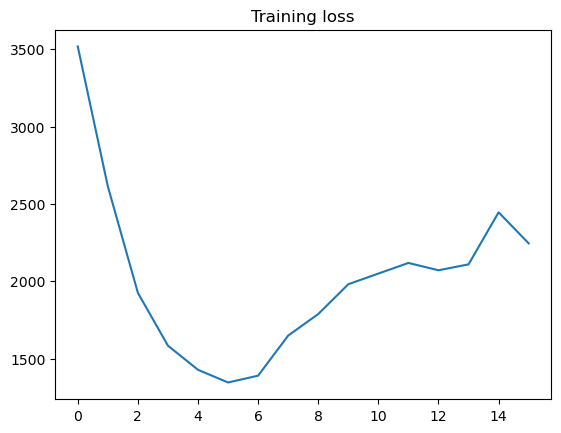

In [341]:
plt.plot(losses)
plt.title("Training loss");

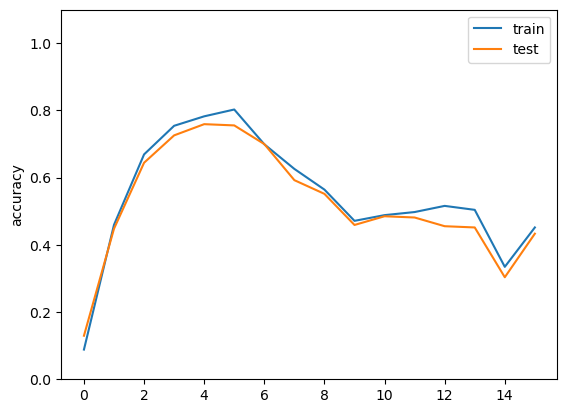

In [342]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

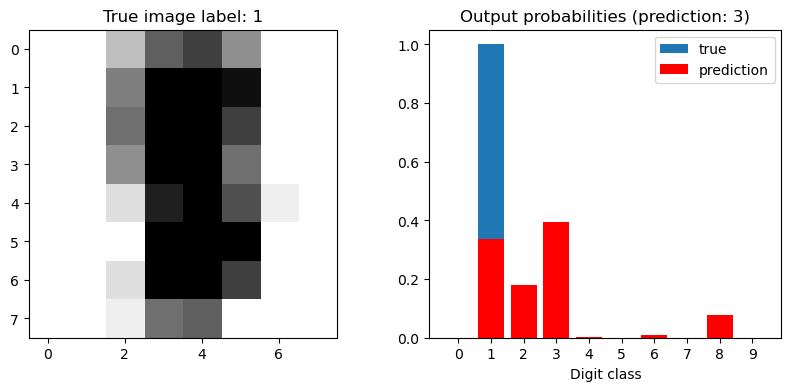

In [343]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

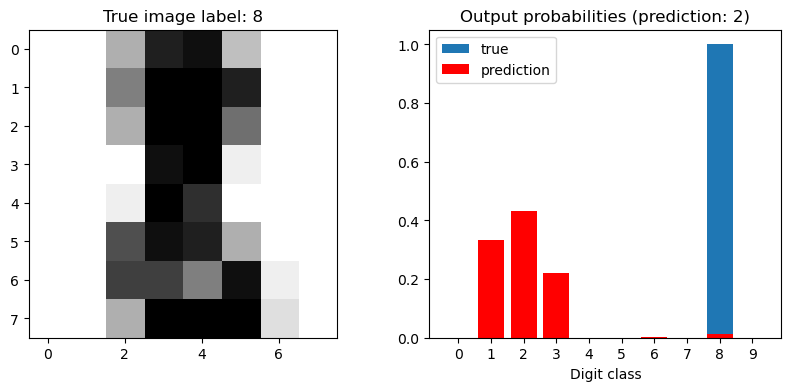

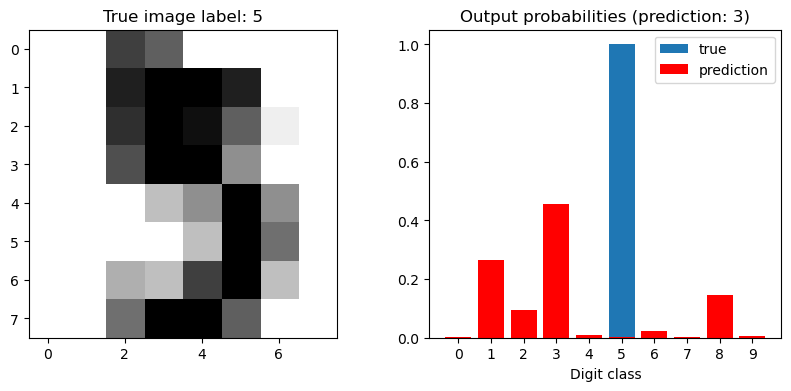

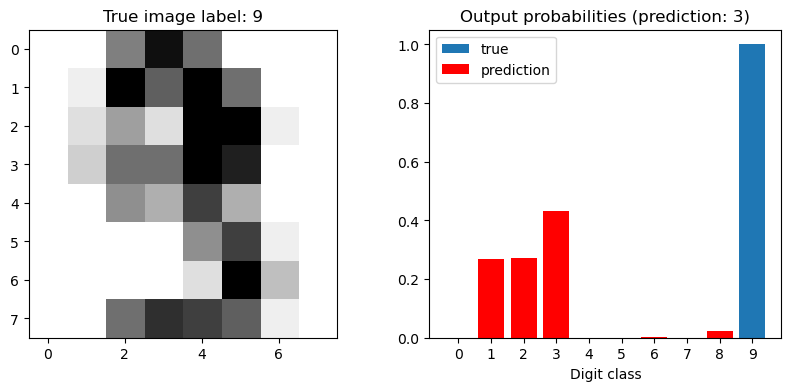

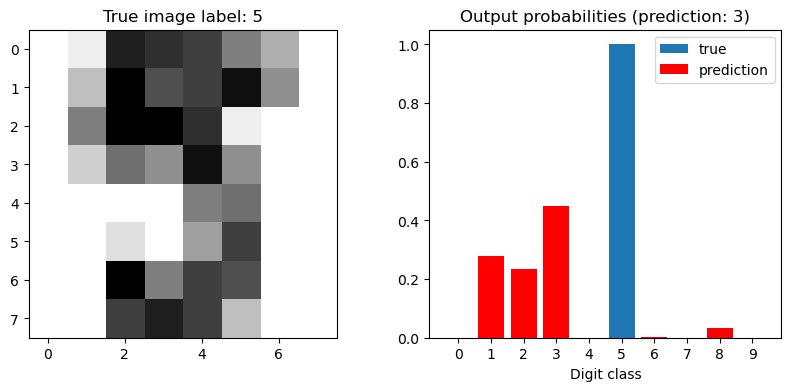

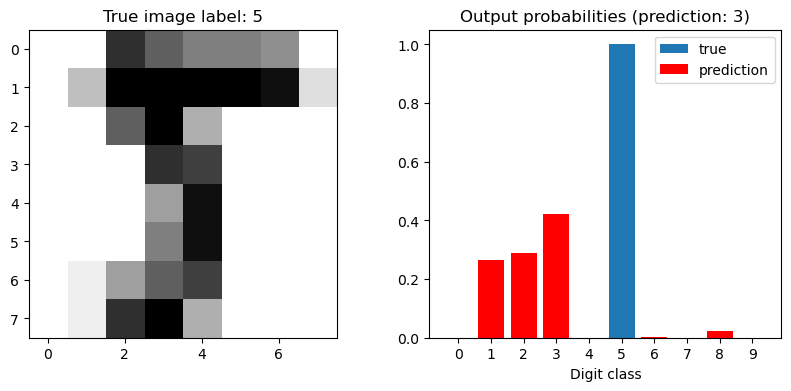

In [344]:
# Your code here
import numpy as np

def find_worst_predictions(model, X, y, n=5):
    # Compute the forward pass to get the predicted probabilities
    y_prob = model.forward(X)

    # Compute the true probabilities (one-hot encoded)
    y_true_onehot = one_hot(model.output_size, y)

    # Compute the absolute errors
    errors = np.abs(y_true_onehot - y_prob).sum(axis=1)

    # Find the indices of the worst predictions
    worst_indices = np.argsort(errors)[-n:]

    return worst_indices

# Find the 5 worst predictions
worst_indices = find_worst_predictions(model, X_test, y_test, n=5)

# Plot the worst predictions
for idx in worst_indices:
    plot_prediction(model, sample_idx=idx)


### Hyper parameters settings

- Experiment with different hyperparameters:
  - learning rate,
  - size of hidden layer,
  - implement the support for a second hidden layer.
  - What is the best test accuracy you can get?

In [345]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(X):
    X = np.clip(X, -500, 500)  # Clip X to prevent overflow or underflow
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    sig = sigmoid(X)
    return sig * (1 - sig)

def softmax(X):
    X_max = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - X_max)  # Subtract the max to avoid overflow in the exponentiation
    return exp / np.sum(exp, axis=-1, keepdims=True)

def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

class NeuralNet:
    """MLP with 1 or 2 hidden layers with sigmoid activations"""

    def __init__(self, input_size, hidden_size1, hidden_size2=None, output_size=10):
        # Initialize the weights for 1 or 2 hidden layers
        self.W_h1 = np.random.uniform(size=(input_size, hidden_size1), high=0.1, low=-0.1)
        self.b_h1 = np.random.uniform(size=hidden_size1, high=0.1, low=-0.1)
        
        if hidden_size2:
            self.W_h2 = np.random.uniform(size=(hidden_size1, hidden_size2), high=0.1, low=-0.1)
            self.b_h2 = np.random.uniform(size=hidden_size2, high=0.1, low=-0.1)
            self.hidden_size2 = hidden_size2
        
        self.W_o = np.random.uniform(size=(hidden_size2 if hidden_size2 else hidden_size1, output_size), high=0.1, low=-0.1)
        self.b_o = np.random.uniform(size=output_size, high=0.1, low=-0.1)

        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.output_size = output_size

    def forward_hidden1(self, X):
        self.Z_h1 = np.dot(X, self.W_h1) + self.b_h1
        return sigmoid(self.Z_h1)

    def forward_hidden2(self, H):
        if hasattr(self, 'W_h2'):
            self.Z_h2 = np.dot(H, self.W_h2) + self.b_h2
            return sigmoid(self.Z_h2)
        return H

    def forward_output(self, H):
        self.Z_o = np.dot(H, self.W_o) + self.b_o
        return softmax(self.Z_o)

    def forward(self, X):
        H1 = self.forward_hidden1(X)
        H2 = self.forward_hidden2(H1)
        Y = self.forward_output(H2)
        return Y

    def loss(self, X, y):
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X)
        return nll(y_onehot, y_pred)

    def grad_loss(self, X, y_true):
        y_true = one_hot(self.output_size, y_true)
        y_pred = self.forward(X)

        error_o = y_pred - y_true
        grad_W_o = np.dot(self.Z_h2.T if hasattr(self, 'Z_h2') else self.Z_h1.T, error_o)
        grad_b_o = np.sum(error_o, axis=0)

        if hasattr(self, 'W_h2'):
            error_h2 = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h2)
            grad_W_h2 = np.dot(self.Z_h1.T, error_h2)
            grad_b_h2 = np.sum(error_h2, axis=0)

            error_h1 = np.dot(error_h2, self.W_h2.T) * dsigmoid(self.Z_h1)
        else:
            error_h1 = np.dot(error_o, self.W_o.T) * dsigmoid(self.Z_h1)

        grad_W_h1 = np.dot(X.T, error_h1)
        grad_b_h1 = np.sum(error_h1, axis=0)

        grads = {"W_h1": grad_W_h1, "b_h1": grad_b_h1, "W_o": grad_W_o, "b_o": grad_b_o}
        if hasattr(self, 'W_h2'):
            grads.update({"W_h2": grad_W_h2, "b_h2": grad_b_h2})
        
        return grads

    def train(self, x, y, learning_rate):
        x = x[np.newaxis, :]
        grads = self.grad_loss(x, y)
    
        self.W_h1 -= learning_rate * grads["W_h1"]
        self.b_h1 -= learning_rate * grads["b_h1"]
        self.W_o -= learning_rate * grads["W_o"]
        self.b_o -= learning_rate * grads["b_o"]
        
        if hasattr(self, 'W_h2'):
            self.W_h2 -= learning_rate * grads["W_h2"]
            self.b_h2 -= learning_rate * grads["b_h2"]
        
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

# Test different configurations

hidden_layer_sizes = [10, 20, 50]
learning_rates = [0.1, 0.01, 0.001]

best_acc = 0
best_config = {}

for hidden_size in hidden_layer_sizes:
    for lr in learning_rates:
        print(f"Testing configuration: hidden_size={hidden_size}, learning_rate={lr}")
        
        # Initialize model with 1 hidden layer
        model = NeuralNet(n_features, hidden_size, output_size=n_classes)
        
        for epoch in range(10):  # number of epochs
            for i, (x, y) in enumerate(zip(X_train, y_train)):
                model.train(x, y, lr)

        train_acc = model.accuracy(X_train, y_train)
        test_acc = model.accuracy(X_test, y_test)

        if test_acc > best_acc:
            best_acc = test_acc
            best_config = {"hidden_size": hidden_size, "learning_rate": lr, "layers": 1}

        print(f"Train accuracy: {train_acc:.3f}, Test accuracy: {test_acc:.3f}")

# Test configuration with 2 hidden layers
for hidden_size in hidden_layer_sizes:
    for lr in learning_rates:
        print(f"Testing configuration: hidden_size={hidden_size}, hidden_size2={hidden_size//2}, learning_rate={lr}")
        
        # Initialize model with 2 hidden layers
        model = NeuralNet(n_features, hidden_size, hidden_size//2, output_size=n_classes)
        
        for epoch in range(10):  # number of epochs
            for i, (x, y) in enumerate(zip(X_train, y_train)):
                model.train(x, y, lr)

        train_acc = model.accuracy(X_train, y_train)
        test_acc = model.accuracy(X_test, y_test)

        if test_acc > best_acc:
            best_acc = test_acc
            best_config = {"hidden_size": hidden_size, "hidden_size2": hidden_size//2, "learning_rate": lr, "layers": 2}

        print(f"Train accuracy: {train_acc:.3f}, Test accuracy: {test_acc:.3f}")

print("Best configuration:", best_config)
print("Best test accuracy:", best_acc)


Testing configuration: hidden_size=10, learning_rate=0.1
Train accuracy: 0.100, Test accuracy: 0.107
Testing configuration: hidden_size=10, learning_rate=0.01
Train accuracy: 0.109, Test accuracy: 0.063
Testing configuration: hidden_size=10, learning_rate=0.001
Train accuracy: 0.961, Test accuracy: 0.937
Testing configuration: hidden_size=20, learning_rate=0.1
Train accuracy: 0.100, Test accuracy: 0.107
Testing configuration: hidden_size=20, learning_rate=0.01
Train accuracy: 0.100, Test accuracy: 0.107
Testing configuration: hidden_size=20, learning_rate=0.001
Train accuracy: 0.978, Test accuracy: 0.956
Testing configuration: hidden_size=50, learning_rate=0.1
Train accuracy: 0.100, Test accuracy: 0.107
Testing configuration: hidden_size=50, learning_rate=0.01
Train accuracy: 0.101, Test accuracy: 0.107
Testing configuration: hidden_size=50, learning_rate=0.001
Train accuracy: 0.985, Test accuracy: 0.981
Testing configuration: hidden_size=10, hidden_size2=5, learning_rate=0.1
Train acc